In [1]:
from IPython.display import display, HTML

main_color = '#5f187f' 
prompt = '#982d80'
strong_main_color = '#221150'

# ----- Notebook Theme -----

html_contents ="""
<!DOCTYPE html>
<html lang="en">
    <head>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Lato&family=Montserrat&display=swap" rel="stylesheet"> 
        <style>
        h1,h2,h3,h4{
            font-family: 'Montserrat', Arial, sans-serif;
            font-weight: bold;
            color: "#221150";
            letter-spacing: 1px;}
        hr{ border: 2px solid #982d80;
             color: #982d80;
           }
        body{
            font-family: 'Lato', sans-serif;
            }        
        </style>
    </head>    
</html>
"""

display(HTML(html_contents))

<h1><center><b>Projet Ummon HealthTech | Détection du grade d'un cancer</b></center></h1>
<h2><center>Analyse exploratoire des données</center></h2>

![Header Image](https://storage.googleapis.com/kaggle-competitions/kaggle/11848/logos/header.png?t=2018-11-15-01-52-19)

<hr>

# **<span>Table des matières</span>**

1. [Structure du jeu de données](#structure)

2. [Chargement des libraries](#chargement)

3. [Chargement du fichier "train_annotations.csv"](#csv)

4. [Correction des noms de fichiers](#correction)

5. [Analyse de la distribution des différentes classes](#analyse_classe)

6. [Ajout de métadonnées supplémentaires](#meta)

7. [Export du nouveau fichier "train_annotations.csv"](#export)

8. [Analayse de la taille des images](#taille)

9. [Nombre de grades par lame](#lames)

10. [Exploration des images](#Exploration)

11. [Génération des images moyennes](#moy)

12. [PCA et Eigenimages](#pca)

13. [Analyse colorimétrique](#col)

### <span id="structure"><b>1. Structure du jeu de données</b></span>
<hr>  

> **train_annotations.csv** - Le fichier contient le nom de fichier ainsi que la classe associée
> 
> **../raw/annotated_regions/** - Le répertoire contenant 5926 histopathologies du col de l'utérus
> 
> - 0️⃣ 1923 images de tissus sains
> 
> - 1️⃣ 1405 images de cancer au grade 1
> 
> - 2️⃣ 1230 images de cancer au grade 2
>
> - 3️⃣ 1368 images de cancer au grade 3

### <span id="chargement"><b>2. Chargement des libraries</b></span>
<hr >

On charge les différentes librairies utiles pour l'analyse exploratoire. Pour que le code fonctionne correctement, il est impératif d'avoir une version de *matplotlib>=3.5.0*.

In [1]:
# import des libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import offsetbox
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import ImageReadMode
from sklearn.decomposition import PCA
from math import ceil
from PIL import Image
import os
import re
import warnings

# On désactive les warnings
warnings.filterwarnings("ignore")

# Paramètres pour dataviz
%matplotlib inline

custom_params = {"axes.spines.right": False,
                 "axes.spines.left": False,
                 "axes.spines.top": False}

sns.set_theme(style="white", 
              palette='magma', 
              rc=custom_params)

# couleurs utilisées pour le thème du notebook :
colors=sns.color_palette('magma', 6).as_hex()
#221150, #5f187f, #982d80, #d3436e, #f8765c, #febb81

In [3]:
libraries = ['pandas', 'numpy', 'matplotlib']
versions = [pd.__version__, np.__version__, matplotlib.__version__]
print('######## Versions ########')
for i in range(len(libraries)):
    print(f'# {libraries[i] : <12}=>{versions[i] : >8} #')
print('##########################')   

######## Versions ########
# pandas      =>   1.4.1 #
# numpy       =>  1.21.5 #
# matplotlib  =>   3.5.1 #
##########################


On prépare ici les différents chemins vers les répertoires ou fichiers.

In [6]:
# Chemin à changer en fonction de l'utilisateur
ROOT = 'C:/Users/gaelp/Documents/Projet_DataScientest/data/raw/annotated_regions/' # Je s'appelle Root
TARGET_PATH = 'C:/Users/gaelp/Documents/Projet_DataScientest/data/raw/train_annotations.csv' 
RAW = 'C:/Users/gaelp/Documents/Projet_DataScientest/data/raw/'
RESIZED = 'C:/Users/gaelp/Documents/Projet_DataScientest/data/raw/resized_regions/'

### <span id="csv"><b>3. Analyse du fichier <i>train_annotations.csv</i></b></span>
<hr >

In [5]:
# On affiche les premières lignes
target = pd.read_csv(TARGET_PATH)
target.head()

annotation_id          filename  annotation_class
0  C12_B132_S12_0  C12_B132_S12.tif                 2
1  C12_B132_S12_1  C12_B132_S12.tif                 3
2  C12_B132_S12_2  C12_B132_S12.tif                 3
3  C12_B132_S12_3  C12_B132_S12.tif                 3
4  C12_B132_S12_4  C12_B132_S12.tif                 3

In [6]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5926 entries, 0 to 5925
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   annotation_id     5926 non-null   object
 1   filename          5926 non-null   object
 2   annotation_class  5926 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 139.0+ KB


### <span id="correction"><b>4. Correction des noms de fichiers</b></span>
<hr >

>On constate que la colonne *filename* ne contient pas les bons noms de fichiers.  
>Le nom correct est obtenu à partir de la colonne *annotation_id* en ajoutant l'extension *jpeg*.

In [7]:
# vérif extensions
target['filename'].apply(lambda x : str(x).split('.')[1]).unique()

array(['tif'], dtype=object)

In [8]:
# On applique la modification de l'extension .tif => .jpeg
target['filename']  = target['annotation_id'].apply(lambda x: str(x)+'.jpeg')

# Vérification 
target['filename'].head()

0    C12_B132_S12_0.jpeg
1    C12_B132_S12_1.jpeg
2    C12_B132_S12_2.jpeg
3    C12_B132_S12_3.jpeg
4    C12_B132_S12_4.jpeg
Name: filename, dtype: object

### <span id="analyse_classe"><b>5. Analayse de la distribution des différentes classes</b></span>
<hr >

On analyse la répartition des grades.

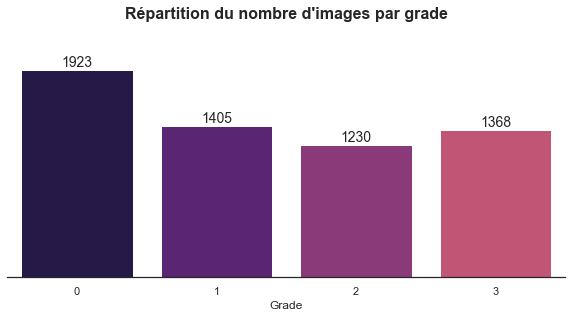

In [9]:
plt.figure(figsize=(10,4))
ax = sns.countplot(data=target, 
              x='annotation_class')
ax.bar_label(ax.containers[0],
             fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.xlabel('Grade')
plt.title("Répartition du nombre d'images par grade\n\n", 
          fontdict={'fontsize':16,
                    'fontweight':'bold'})
plt.show()

On crée une nouvelle feature pour savoir si l'image contient des cellules cancereuses ou pas.

In [10]:
target['binary_class'] = target['annotation_class'].apply(lambda x: 0 if x==0 else 1)

In [11]:
pd.crosstab(target['binary_class'], target['annotation_class'])

annotation_class     0     1     2     3
binary_class                            
0                 1923     0     0     0
1                    0  1405  1230  1368

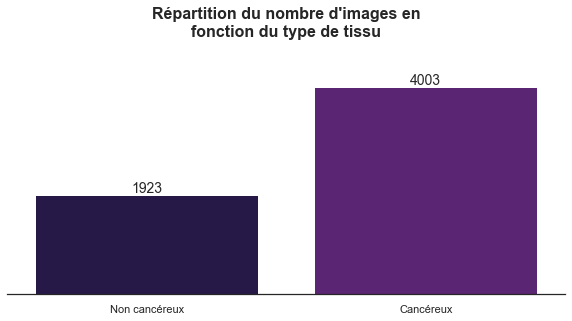

In [12]:
plt.figure(figsize=(10,4))
ax = sns.countplot(data=target, 
              x='binary_class')
ax.bar_label(ax.containers[0],
             fontsize=14)
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.xticks(ticks=[0,1], 
           labels=['Non cancéreux', 'Cancéreux'])
plt.title("Répartition du nombre d'images en\nfonction du type de tissu\n\n", 
          fontdict={'fontsize':16,
                    'fontweight':'bold'})
plt.show()

Le jeu données contient moins de données de tissus sains que cancéreux. Il faudra peut-être corriger cet aspect au moment de la création des jeux de train et test.

### <span id="meta"><b>6. Ajout de métadonnées supplémentaires</b></span>
<hr >

On ajoute de nouvelles colonnes contenant les informations contenues dans le nom du fichier :
> * *CXX* : numéro de centre
> * *BXX_SXX* : numéro de lame
> * *XXX* : id de l'image

On ajoute aussi les champs suivants :
> * *img_col_dim* : nombre de couches de l'image (3 si RGB, 1 pour une image en nuance de gris)
> * *img_width* : largeur de l'image
> * *img_height* : hauteur de l'image

In [13]:
# On ajoute le numéro du centre
target['id_centre'] = target['filename'].apply(lambda x: str(x).split('_')[0])

In [14]:
# On ajoute le numéro de lame
re_lame = re.compile(r'([B-C][0-9]{3}_S[0-9]{2})')
target['id_lame'] = target['filename'].str.extract(re_lame)

In [15]:
# On ajoute, pour une lame donnée, l'identifiant
target['id_image'] = target['filename'].apply(lambda x: str(x).split('_')[-1].split('.')[0])

In [16]:
# On intègre la taille des images
target['img_col_dim']=target['filename'].apply(lambda x: torchvision.io.read_image(ROOT+x).numpy().shape[0]).astype('int')

In [17]:
target['img_width']=target['filename'].apply(lambda x: torchvision.io.read_image(ROOT+x).numpy().shape[1]).astype('int')

In [18]:
target['img_height']=target['filename'].apply(lambda x: torchvision.io.read_image(ROOT+x).numpy().shape[2]).astype('int')

In [19]:
target.head()

annotation_id             filename  annotation_class  binary_class  \
0  C12_B132_S12_0  C12_B132_S12_0.jpeg                 2             1   
1  C12_B132_S12_1  C12_B132_S12_1.jpeg                 3             1   
2  C12_B132_S12_2  C12_B132_S12_2.jpeg                 3             1   
3  C12_B132_S12_3  C12_B132_S12_3.jpeg                 3             1   
4  C12_B132_S12_4  C12_B132_S12_4.jpeg                 3             1   

  id_centre   id_lame id_image  img_col_dim  img_width  img_height  
0       C12  B132_S12        0            3       1304        1304  
1       C12  B132_S12        1            3       1304        1304  
2       C12  B132_S12        2            3       1304        1304  
3       C12  B132_S12        3            3       1304        1304  
4       C12  B132_S12        4            3       1304        1304

### <span id="export"><b>7. Export du nouveau fichier "train_annotations.csv"</b></span>
<hr >

In [20]:
filenames = [name for name in os.listdir(ROOT) if os.path.splitext(name)[-1] == '.jpeg']
filenames.sort()

In [21]:
liste_images = []
label_df = target[['filename', 'annotation_class']].sort_values(by='filename') #'binary_class',
for i, name in enumerate(filenames):
    test = name == label_df.iloc[i]['filename']
    if test :
        liste_images.append(label_df.iloc[i]['filename'])

In [22]:
# On vérifie que le fichier cvs contient toutes les images du répertoire
test = set(filenames) == set(liste_images)
if test == True :
    print('Toutes les images sont bien répertoriées dans le fichier csv')
    print('Export des nouvelles données dans le fichier : '+ RAW + 'label_df.csv')
    label_df.reset_index(drop=True).to_csv(RAW+'label_df.csv', index=False)
else : 
    print('Certaines images sont absentes du répertoire ou du fichier csv')

Toutes les images sont bien répertoriées dans le fichier csv
Export des nouvelles données dans le fichier : C:/Users/gaelp/Documents/Projet_DataScientest/data/raw/label_df.csv


### <span id="images"><b>8. Analyse de la taille des images</b></span>
<hr >

Il eput être intéressant de savoir comment varie la taille de l'image en fonction des centres.

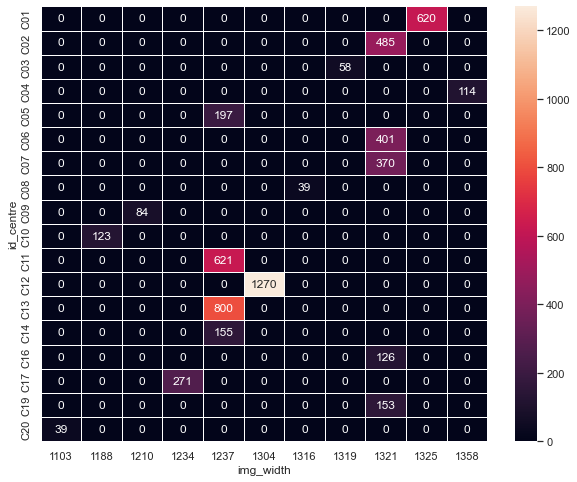

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.crosstab(target['id_centre'], target['img_width']), 
            annot=True, 
            fmt='d', 
            linewidths=0.5, 
            )
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:
#5f187f;
           font-size:110%;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;"><b>Conclusion :</b> chaque centre possède un format dédié, cependant on remarque que deux formats sont plus courants que les autres : <i>1237 x 1237</i> et <i>1321 x 1321</i>.
</p>
</div>

Nous allons maintenant étudier la répartition du nombre d'échantillons par centre.

In [24]:
new_data = pd.DataFrame(data=target.groupby('id_centre')['filename'].count()).reset_index()
new_data.columns = ['id_centre', 'total']

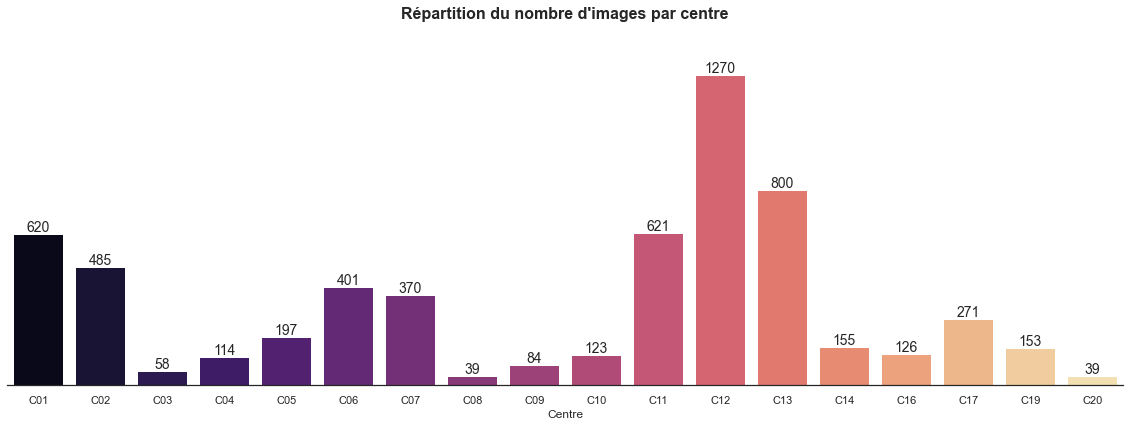

In [25]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=new_data, 
                 palette='magma',
                 x='id_centre',
                 y='total')
ax.bar_label(ax.containers[0],
             fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.xlabel('Centre')
plt.title("Répartition du nombre d'images par centre\n\n", 
          fontdict={'fontsize':16,
                    'fontweight':'bold'})
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:
#5f187f;
           font-size:110%;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;"><b>Conclusion :</b> le nombre d'échantillons par centre n'est pas identique, il faudra peut-être utiliser des techniques d'oversampling pour équilibrer le jeu de données. Chaque centre ayant un protocole de coloration différent, il est important qu'ils soient tous représentés de façon equivalente.
</p>
</div>

### <span id="lames"><b>9. Nombre de grades par lame</b></span>
<hr >

Nous regardons maintenant s'il est possible d'avoir différent grades sur un même échantillon, et si oui quelle est le nombre de grades maximums.

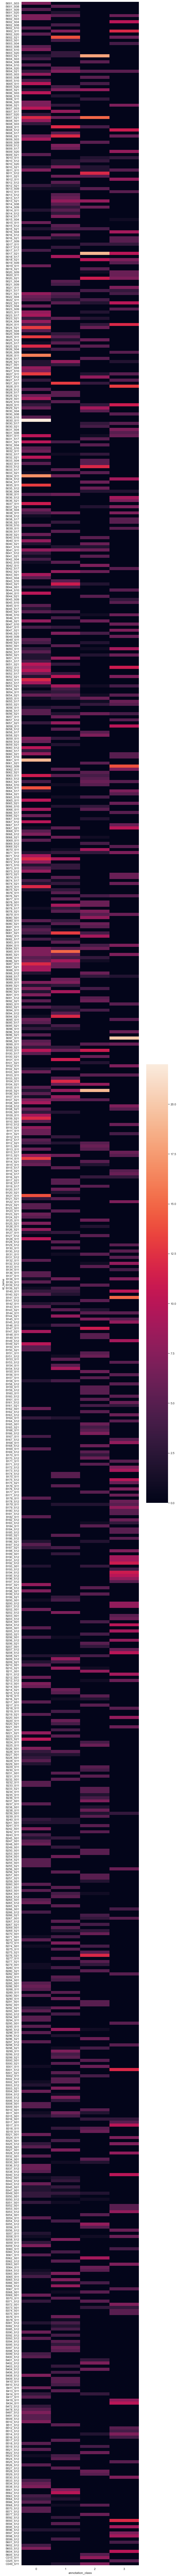

In [26]:
plt.figure(figsize=(10,180))
sns.heatmap(pd.crosstab(target['id_lame'], target['annotation_class'])           )
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:
#5f187f;
           font-size:110%;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;"><b>Conclusion :</b> On remarque de certaines lames peuvent avoir des cellules saines ainsi que des cellules cancéreuses de chaque grade. 
</p>
</div>

In [27]:
# On crée une nouvelle dataframe contenant les informations synthétiques de nombre de grades par lame
count = pd.crosstab(target['id_lame'], target['annotation_class'])
count = count.astype('bool').astype('int')
count['nb_grades'] = count.sum(axis=1)
count_total = pd.DataFrame(data = count.groupby('nb_grades')[0].count())

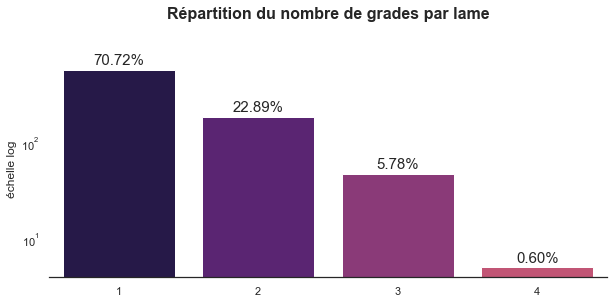

In [28]:
plt.figure(figsize=(10,4))
g = sns.barplot(x=[1, 2, 3, 4], 
            y=count_total.iloc[:,0], 
            data=count_total)
plt.title('Répartition du nombre de grades par lame\n\n',
          fontdict={'fontsize':16,
                    'fontweight':'bold'})
g.set_yscale("log")
for i, p in enumerate(g.patches):
    g.annotate(format(count_total.iloc[i,0]/count_total.values.sum()*100, '.2f')+'%', 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', 
               va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points',
               fontsize=15)
plt.xlabel('')
plt.ylabel('échelle log')
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:
#5f187f;
           font-size:110%;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;"><b>Conclusion :</b> On remarque que certaines lames peuvent avoir tous les grades possibles." 
</p>
</div>

### <span id="exploration"><b>10. Exploration des images</b></span>
<hr >

#### **10.1. Affichage d'un échantillon aléatoire d'images**

Nous affichons ici quelques images tirées de façon aléatoires avec leur classe.

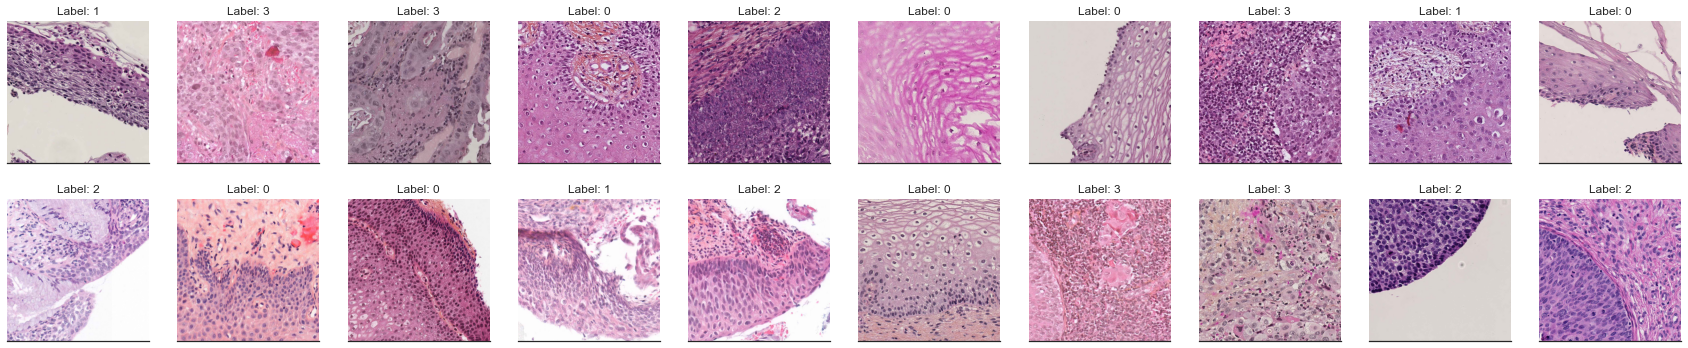

In [8]:
full_train_df = pd.read_csv(RAW+'label_df.csv')

fig = plt.figure(figsize=(30, 6))
all_imgs = os.listdir(RESIZED)
for idx, img in enumerate(np.random.choice(all_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(RESIZED + img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['filename'] == img, 'annotation_class'].values[0]
    ax.set_title('Label: %s'%lab)

#### **10.2 Conversion des images en matrices**

Pour faciliter le traitement des images, nous allons les convertir en matrice pour effectuer différents calculs :
>- image moyenne pour les tissus sains
>- image moyenne pour les tissus cancéreux
>- variation moyenne de l'image pour les tissus sains
>- variation moyenne de l'image pour les tissus cancéreux

In [9]:
mask = full_train_df['annotation_class']==0
avec_cancer = full_train_df[~mask]
sans_cancer = full_train_df[mask]

In [10]:
sans_cancer.head()

filename  annotation_class
4  C01_B008_S01_0.jpeg                 0
5  C01_B008_S01_1.jpeg                 0
6  C01_B008_S01_2.jpeg                 0
7  C01_B008_S01_3.jpeg                 0
8  C01_B008_S01_4.jpeg                 0

In [11]:
avec_cancer.head()

filename  annotation_class
0   C01_B003_S01_0.jpeg                 1
1   C01_B003_S01_1.jpeg                 1
2   C01_B003_S01_2.jpeg                 1
3   C01_B003_S01_3.jpeg                 1
14  C01_B027_S01_2.jpeg                 1

### <span id="moy"><b>11. Génération des images moyennes</b></span>
<hr >

Pour des raisons techniques de rapidement de traitement et de calcul, les images sont lues en nuances de gris dans cette partie.

In [33]:
vec_sans_cancer = []
for i in sans_cancer.index:
    t = torchvision.io.read_image(RESIZED+sans_cancer.loc[i,'filename'], 
                                  mode=ImageReadMode.GRAY
                                 )
    vec_sans_cancer.append(t.numpy())

In [34]:
img_no_cancer = np.mean(vec_sans_cancer, axis=0).astype(int)

In [35]:
img_std_no_cancer = np.std(vec_sans_cancer, axis=0).astype(int)

In [39]:
vec_avec_cancer = []
# On limite aux 2000 premières images pour limiter le temps de calcul
for i in avec_cancer.index[:2000]:
    t = torchvision.io.read_image(RESIZED+avec_cancer.loc[i,'filename'], 
                                  mode=ImageReadMode.GRAY
                                 )
    vec_avec_cancer.append(t.numpy())

In [40]:
img_cancer = np.mean(vec_avec_cancer, axis=0).astype(int)

In [41]:
img_std_cancer = np.std(vec_avec_cancer, axis=0).astype(int)

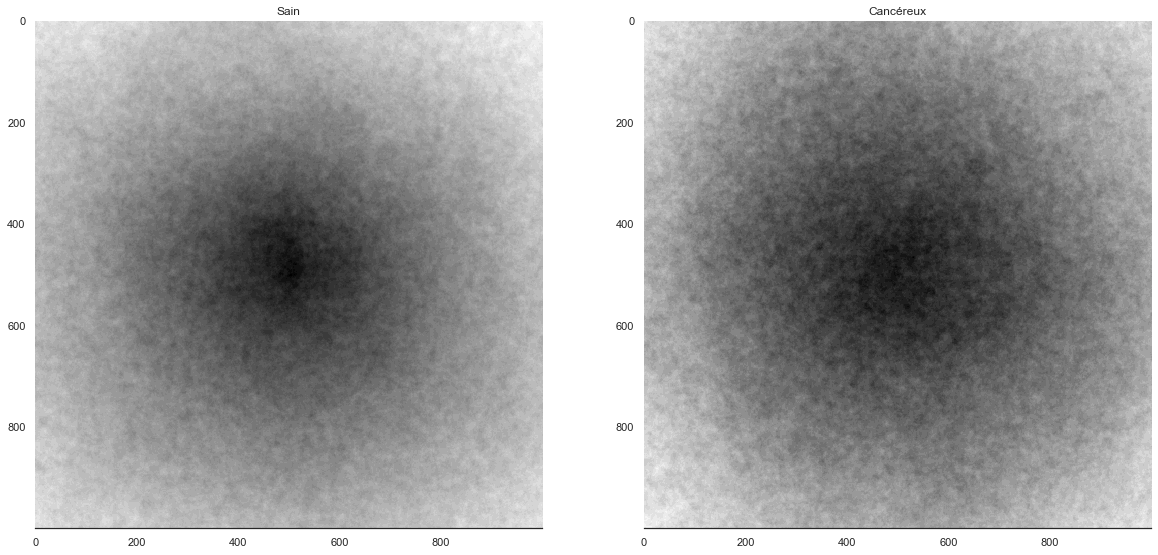

In [42]:
# Affichage de l'image moyenne
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(np.moveaxis(img_no_cancer, 0, -1), #[...,0], #[0,:,:], 
           cmap='gray', 
           interpolation='None')
plt.title('Sain')
plt.subplot(122)
plt.imshow(np.moveaxis(img_cancer, 0, -1), #[...,0], #[0,:,:], 
           cmap='gray',
           interpolation='None')
plt.title('Cancéreux')
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:
#5f187f;
           font-size:110%;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;"><b>Conclusion :</b> l'image moyenne des images classées comme cancéreuses montre une tache plus large que celle sur l'image moyenne des cellules saines. 
</p>
</div>

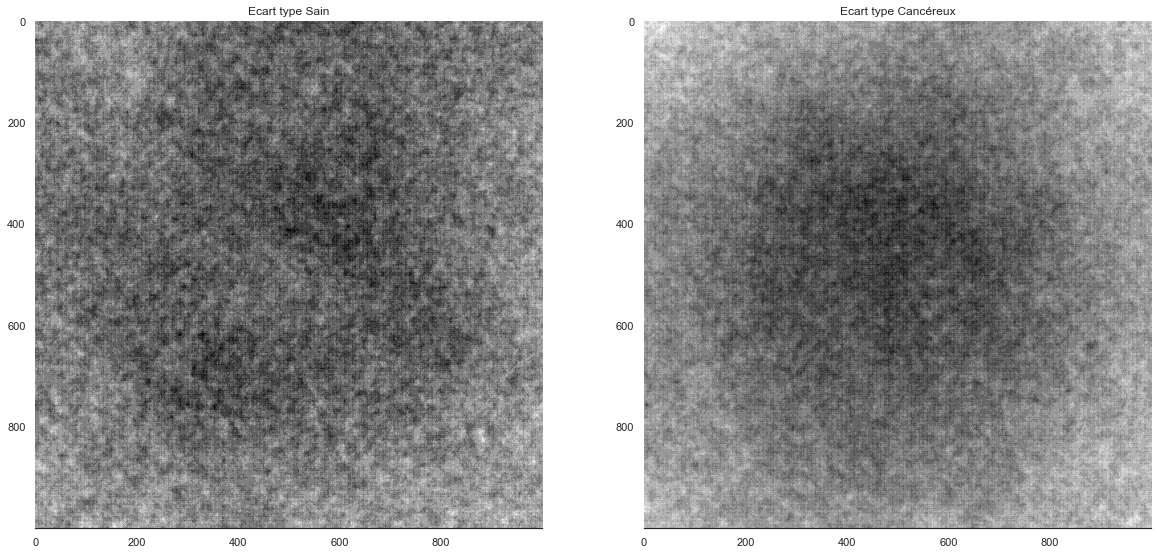

In [43]:
# Affichage de l'écart type
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(np.moveaxis(img_std_no_cancer, 0, -1), # On utilise moveaxis pour réordonner les dimensions pour passer d'un format PyTorch à Matplotlib
           cmap='gray', 
           interpolation='None')
plt.title('Ecart type Sain')
plt.subplot(122)
plt.imshow(np.moveaxis(img_std_cancer, 0, -1),
           cmap='gray',
           interpolation='None')
plt.title('Ecart type Cancéreux')
plt.show()

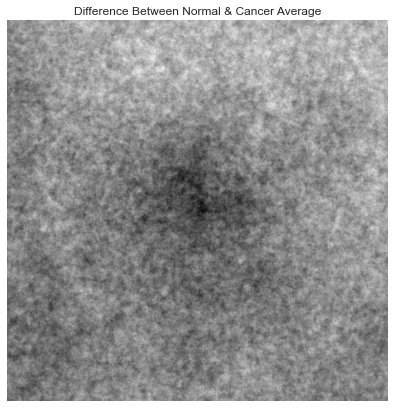

In [44]:
contrast_mean = img_no_cancer - img_cancer
plt.figure(figsize=(7,7))
plt.imshow(np.moveaxis(contrast_mean, 0, -1), 
           cmap='gray')
plt.title(f'Difference Between Normal & Cancer Average')
plt.axis('off')
plt.show()

### <span id="pca"><b>12. PCA et Eigenimages</b></span>
<hr >

Dans cette partie du notebook, nous allons effectuter une PCA sur un échantillon d'images (10% du jeu de données)

In [45]:
echantillon = full_train_df.sample(frac=0.1)

In [59]:
mat_vide = []
for i in echantillon.index:
    t = torchvision.io.read_image(RESIZED+echantillon.loc[i,'filename'], 
                                  mode=ImageReadMode.GRAY)
    mat_vide.append(t.ravel().numpy())

In [63]:
df_pca_ech = pd.DataFrame(data=mat_vide)

In [71]:
pca = PCA(n_components = 0.95)
pca_ech = pca.fit_transform(df_pca_ech)

In [72]:
pca.n_components_

464

In [73]:
def plot_pca(pca):
    # plot eigenimages in a grid
    n = 25 #pca.n_components_
    fig = plt.figure(figsize=(12, 12))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(1000,1000), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

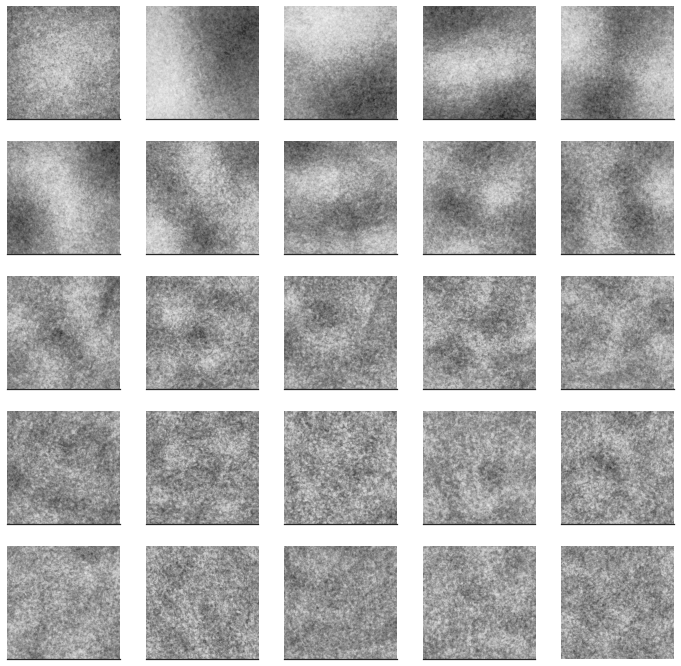

In [75]:
plot_pca(pca)

In [ ]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            # Modification du code pour réduire la taille de l'image
            test = np.moveaxis(images[i], 0, -1)
            test=Image.fromarray(test[:,:,0], mode='L').resize((80,80))
            test=np.array(test) 
            # Fin modification
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(test,
                                      #images[i], 
                                      cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

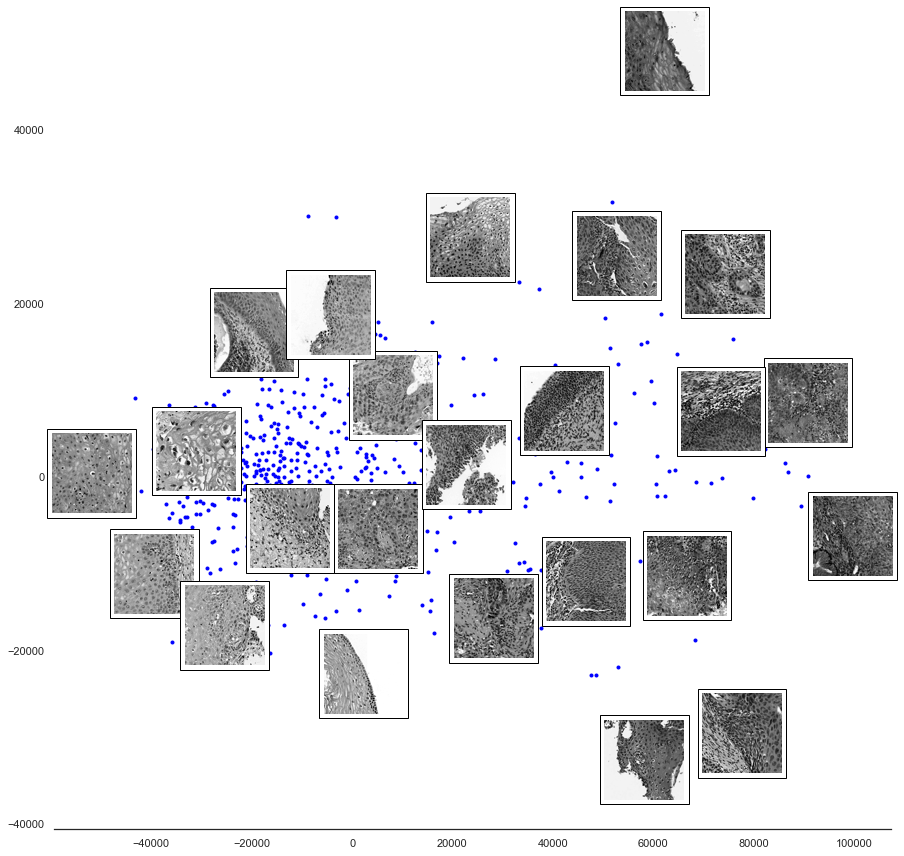

In [69]:
fig, ax = plt.subplots(figsize=(15, 15))
# Ajouter pca avec grades
plot_components(df_pca_ech,
                model=PCA(n_components=2),
                images=np.array(df_pca_ech).reshape((-1, 1, 1000, 1000)),
                cmap = 'gray',
                thumb_frac = .1)

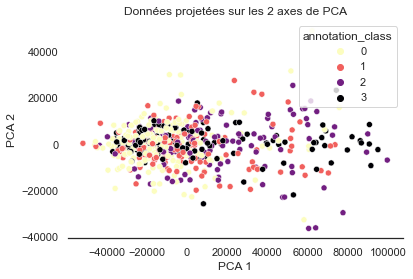

In [81]:
fig = plt.figure()

ax = fig.add_subplot(111)
sns.scatterplot(pca_ech[:,0], 
                pca_ech[:,1], 
                hue = echantillon['annotation_class'], 
                palette='magma_r'
               )

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

ax.set_title("Données projetées sur les 2 premiers axes de PCA")
plt.show()

### <span id="col"><b>13. Analyse colorimétrique</b></span>
<hr >

In [12]:
#On charge les images en couleur
rgb_vec_sans_cancer = []
for i in sans_cancer.index:
    t = torchvision.io.read_image(RESIZED+sans_cancer.loc[i,'filename'], 
                                  #mode=ImageReadMode.GRAY
                                 )
    rgb_vec_sans_cancer.append(t.numpy())

In [13]:
rgb_img_no_cancer = np.mean(rgb_vec_sans_cancer, axis=0).astype(int)

In [14]:
rgb_vec_avec_cancer = []
# On limite le nombre d'images chargées pour limiter l'usage de la RAM
for i in avec_cancer.index[:1000]:
    t = torchvision.io.read_image(RESIZED+avec_cancer.loc[i,'filename'], 
                                  #mode=ImageReadMode.GRAY
                                 )
    rgb_vec_avec_cancer.append(t.numpy())

In [15]:
rgb_img_cancer = np.mean(rgb_vec_avec_cancer, axis=0).astype(int)

In [16]:
print('Stats tissus cancereux : ')
print('************************')
print(f'Intensité min : {rgb_img_cancer.min() : >5}')
print(f'Intensité max : {rgb_img_cancer.max() : >5}')
print(f'Intensité moy : {rgb_img_cancer.mean().astype(int) : >5}')
print('\nStats tissus sains :')
print('************************')
print(f'Intensité min : {rgb_img_no_cancer.min() : >5}')
print(f'Intensité max : {rgb_img_no_cancer.max() : >5}')
print(f'Intensité moy : {rgb_img_no_cancer.mean().astype(int) : >5}')

Stats tissus cancereux : 
************************
Intensité min :   109
Intensité max :   179
Intensité moy :   151

Stats tissus sains :
************************
Intensité min :   136
Intensité max :   206
Intensité moy :   179


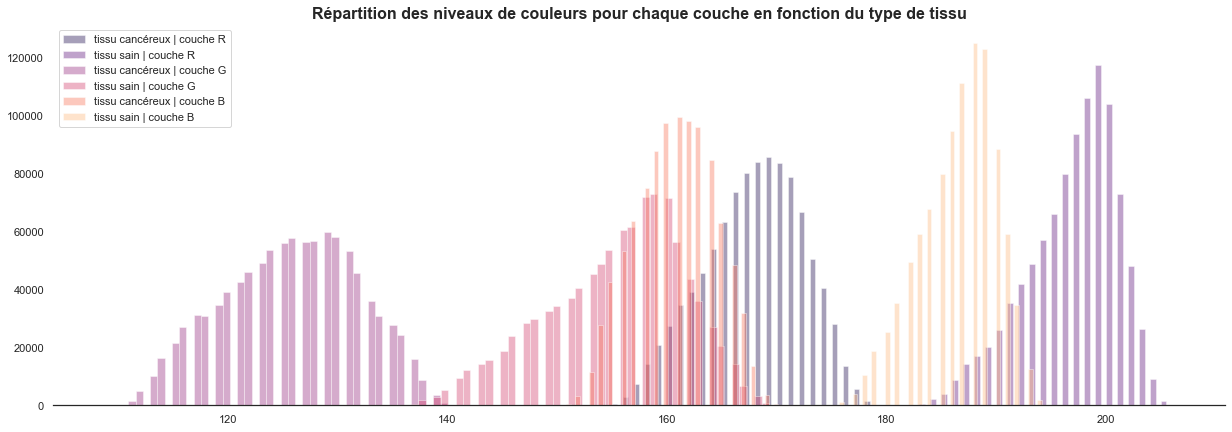

In [25]:
color = ['R', 'G', 'B']

plt.figure(figsize=(21,7))
for i in range(3):
    c=111
    plt.subplot(c)
    sns.distplot(rgb_img_cancer[i,:,:], 
                label='tissu cancéreux | couche '+str(color[i]), 
                kde=False)
    sns.distplot(rgb_img_no_cancer[i,:,:], 
                label='tissu sain | couche '+str(color[i]), 
                kde=False)
    plt.legend()
    c+=10
plt.title('Répartition des niveaux de couleurs pour chaque couche en fonction du type de tissu', fontdict={'fontsize':16,
                    'fontweight':'bold'})
plt.show();